# RecSys Challenge 2022 Research Notebook

## Introduction

Authors : 
- Henri Jamet <henri.jamet@epita.fr>
- Corentin Duchene <corentin.duchene@epita.fr>
- Adrien Merat <adrien.merat@epita.fr>
- Erwan Goudard <erwan.goudard@epita.fr>

Projet :
- http://www.recsyschallenge.com/2022/index.html#about
- http://www.recsyschallenge.com/2022/dataset.html

## Data Exploration

The data should first be downloaded and unpacked into the data folder at the root of this project. So we should have :

```shell
data
├── README.txt
├── README_win.txt
├── candidate_items.csv
├── item_features.csv
├── test_final_sessions.csv
├── test_leaderboard_sessions.csv
├── train_purchases.csv
└── train_sessions.csv
```


**Let's load our data**

In [2]:
import pandas as pd
import os

PATH_DATA = os.path.join("..", "data")

train_session_df = pd.read_csv(os.path.join(PATH_DATA, "train_sessions.csv"))
train_purchase_df = pd.read_csv(os.path.join(PATH_DATA, "train_purchases.csv"))
candidate_items_df = pd.read_csv(os.path.join(PATH_DATA, "candidate_items.csv"))
item_features_df = pd.read_csv(os.path.join(PATH_DATA, "item_features.csv"))
test_final_sessions_df = pd.read_csv(os.path.join(PATH_DATA, "test_final_sessions.csv"))
test_leaderboard_sessions_df = pd.read_csv(os.path.join(PATH_DATA, "test_leaderboard_sessions.csv"))

dict = {"train_session_df" : train_session_df, "train_purchase_df" : train_purchase_df, "candidate_items_df" : candidate_items_df, "item_features_df" : item_features_df, "test_final_sessions_df" : test_final_sessions_df, "test_leaderboard_sessions_df" : test_leaderboard_sessions_df}
for key in dict:
    print(key)
    print(dict[key].head(1), end="\n\n")

train_session_df
   session_id  item_id                     date
0           3     9655  2020-12-18 21:25:00.373

train_purchase_df
   session_id  item_id                     date
0           3    15085  2020-12-18 21:26:47.986

candidate_items_df
   item_id
0        4

item_features_df
   item_id  feature_category_id  feature_value_id
0        2                   56               365

test_final_sessions_df
   session_id  item_id                     date
0          61    27088  2021-06-01 08:12:39.664

test_leaderboard_sessions_df
   session_id  item_id                     date
0          26    19185  2021-06-16 09:53:54.158



*How many different items does exist?*

In [3]:
distinct_item_number = len(item_features_df.item_id.unique())
print("Unique item number :", distinct_item_number)
print("Item id are unique : ", item_features_df.item_id.nunique() == len(item_features_df.item_id.unique()))

Unique item number : 23691
Item id are unique :  True


*How many different sessions does exist?*

In [4]:
distinct_session_number = len(pd.concat([train_session_df.session_id, train_purchase_df.session_id]).unique())
print("Unique user number :", distinct_session_number)

Unique user number : 1000000


*Does session always look an item before buying it?*

In [5]:
import numpy as np

print("A user never look at one item before buying it.")
pd.merge(train_purchase_df, train_session_df, on=['session_id','item_id'], how='left', indicator='Exist')["Exist"].value_counts()

A user never look at one item before buying it.


left_only     1000000
right_only          0
both                0
Name: Exist, dtype: int64

*Can a session look at items without buying any?*

In [6]:
print("Every session bought exactly one item.")

pd.merge(train_purchase_df, train_session_df, on=['session_id'], how='left', indicator='Exist')["Exist"].value_counts()

Every session bought exactly one item.


both          4743820
left_only           0
right_only          0
Name: Exist, dtype: int64

*What is the average number of different items every user usually look?*

In [7]:
print("Average number of items seen by user :", train_session_df.groupby("session_id").count()["item_id"].mean())

Average number of items seen by user : 4.74382


*How many feature does exist?*

In [8]:
print("The number of different item features is :")
print(len(item_features_df["feature_category_id"].unique()))

The number of different item features is :
73


*How many items have the same feature?*

Text(0.5, 1.0, 'Number of different items features')

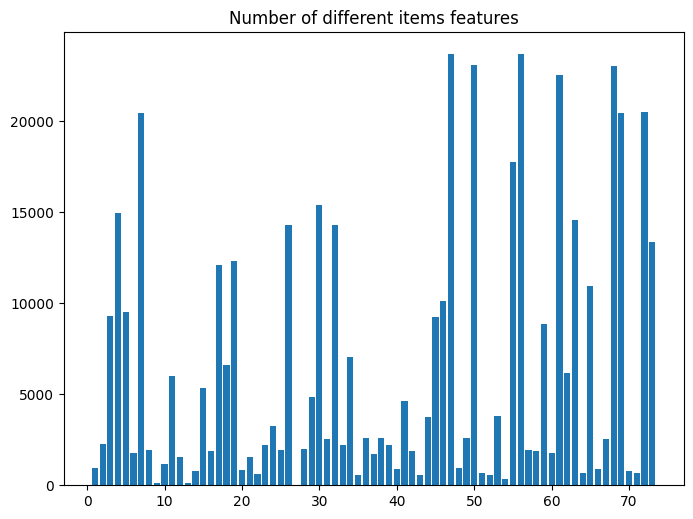

In [9]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
nbr = item_features_df.groupby("feature_category_id").count()["item_id"]
plt.bar(x=nbr.index, height=nbr.values)
plt.title("Number of different items features")

*How many feature en feature_score items have in commun generaly?*

This question is quite complex so we will first create a function giving this number for every items compared to one given because we will probably need this function soon or later anyway.

In [10]:
item_features_df.head(1)

,item_id,feature_category_id,feature_value_id
0,2,56,365


In [11]:

def get_item_similarity(item_features_df, item_id):
    """Get the similarity between the given item and all the others based on their features and feature values.

    Args:
        item_features_df (pd.DataFrame): The item features dataframe.
        item_id_1 (int): The id of the first item

    Returns:
        (pd.DataFrame): item | similar_feature_id | similar_value_id
    """
    item_df = item_features_df[item_features_df.item_id == item_id]
    if len(item_df) == 0:
        return None
    same_feature_id = item_features_df[item_features_df.feature_category_id.isin(item_df.feature_category_id)]
    same_value_id = same_feature_id[same_feature_id.feature_value_id.isin(item_df.feature_value_id)]
    return pd.concat([same_feature_id.groupby("item_id").count().feature_category_id.drop(index=item_id).rename("similar_feature_id"), same_value_id.groupby("item_id").count().feature_value_id.drop(index=item_id).rename("similar_value_id")], axis=1)

In [12]:
import numpy as np

ESTIMATION_SAMPLE_NUMBER = 1000

similar_feature_id = []
similar_value_id = []
for _, item_id in item_features_df.sample(ESTIMATION_SAMPLE_NUMBER).item_id.items():
    similarity = get_item_similarity(item_features_df, item_id) / distinct_item_number
    if similarity is None:
        continue
    similarity = similarity.sum()
    similar_feature_id.append(similarity.similar_feature_id)
    similar_value_id.append(similarity.similar_value_id)

average_similar_feature = np.mean(similar_feature_id)
average_similar_value = np.mean(similar_value_id)
print("Average number of similar features between items :", average_similar_feature)
print("Average number of similar feature values between items :", average_similar_value)
    

Average number of similar features between items : 12.69805862985944
Average number of similar feature values between items : 5.012563378498164


## Data Transformation

**Let's add a score to every combination of user-item**

In [13]:
train_rating_df = pd.concat([train_session_df.assign(rating=1), train_purchase_df.assign(rating=2)])
train_set_df = train_rating_df.rename(columns={"session_id" : "user_id", "rating" : "raw_ratings"}).sample(len(train_rating_df))
train_set_df

,user_id,item_id,date,raw_ratings
180033,168600,16065,2020-04-22 01:17:10.88,1
3689500,3449572,22576,2021-03-08 16:05:27.428,1
1810652,1692032,7792,2020-01-29 23:03:03.792,1
4268900,3994853,12251,2020-04-29 17:02:44.991,1
3333758,3117436,20381,2021-02-25 11:11:50.297,1
...,...,...,...,...
767043,717866,20947,2020-03-10 10:05:00.026,1
4010258,3751842,27564,2021-04-07 13:02:24.972,1
3388966,3170046,8498,2020-08-29 20:43:11.509,1
575431,538266,24630,2021-05-08 08:57:30.119,1


**Let's create a SURPRISE training dataset**

In [14]:
TRAIN_SET_REDUCED_SIZE = 10000

import surprise

rating_reader = surprise.Reader(rating_scale=(1, 2))
train_set = surprise.dataset.Dataset.load_from_df(df=train_set_df[["user_id", "item_id", "raw_ratings"]], reader=rating_reader)
train_set_reduced = surprise.dataset.Dataset.load_from_df(df=train_set_df[["user_id", "item_id", "raw_ratings"]].iloc[:TRAIN_SET_REDUCED_SIZE], reader=rating_reader)

## Metrics

## Models

### Let's train a simple Suprise Model

In [14]:
model = surprise.SVD()

surprise.model_selection.cross_validate(model, train_set_reduced, measures=["RMSE"], cv=5, verbose=True, n_jobs=-1)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3757  0.3723  0.3744  0.3827  0.3681  0.3746  0.0048  
Fit time          0.22    0.22    0.22    0.24    0.22    0.22    0.01    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([0.37569936, 0.37226731, 0.37435215, 0.38270867, 0.36814385]),
 'fit_time': (0.2183372974395752,
  0.2168571949005127,
  0.2159743309020996,
  0.23520493507385254,
  0.2207329273223877),
 'test_time': (0.008212566375732422,
  0.0067980289459228516,
  0.006914377212524414,
  0.0077245235443115234,
  0.009037494659423828)}

### Let's Compare our models

In [16]:
model_list = [surprise.NormalPredictor(), surprise.BaselineOnly(), surprise.KNNBaseline(), surprise.KNNBasic(), surprise.KNNWithMeans(), surprise.KNNWithZScore(), surprise.SlopeOne(), surprise.SVD(), surprise.SVDpp(), surprise.NMF(), surprise.CoClustering(), surprise.SlopeOne()]

result = {}
for model in model_list:
    scores = surprise.model_selection.cross_validate(model, train_set_reduced, measures=["RMSE"], cv=5, verbose=False)
    result[model.__class__.__name__] = scores["test_rmse"].mean()

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

In [17]:
# ------------------------- BEST ALGORITHMS WITH RMSE ------------------------ #
sorted(result.items(), key=lambda x: x[1])

[('SVD', 0.3818565797258008),
 ('KNNBaseline', 0.38216215424260536),
 ('BaselineOnly', 0.3822883295988969),
 ('SVDpp', 0.3827282056414258),
 ('KNNBasic', 0.3829054545305815),
 ('NMF', 0.38292314567874247),
 ('KNNWithZScore', 0.38309290607179136),
 ('KNNWithMeans', 0.3833555497718481),
 ('SlopeOne', 0.3833560835185067),
 ('CoClustering', 0.3834550686536672),
 ('NormalPredictor', 0.4770260805604528)]

### Now, lets perform some Grid Search on our best models

We know that a very similar class exists in Surprise and Sklearn. However, in order to perfectly control its behaviour and to be able to run this code in parallel on the LSE cluster, we preferred to reimplement the gridSearch in our own way.

In [18]:
import sklearn.model_selection

class MyCrossValidation:
    def __init__(self, model, params):
        self.model_list = [
            (model(**args, verbose=False), args)
            for args in list(sklearn.model_selection.ParameterGrid(params))
        ]
        self.full_train_set = train_set_reduced.build_full_trainset()

    def __train_test_model(self, model, params, verbose=1):
        model.fit(
            self.full_train_set,
        )
        predictions = model.test(self.full_train_set.build_testset())
        score = surprise.accuracy.rmse(
            predictions, verbose=True if verbose == 2 else False
        )
        if verbose == 1:
            print("Params {} :".format(str(params)), score)
        return (params, score)

    def __call__(self, verbose=1):
        res = []
        while len(self.model_list):
            model, params = self.model_list.pop()
            if verbose == 1:
                print("{} left".format(len(self.model_list)), end=" --- ")
            res.append(self.__train_test_model(model, params, verbose))
            del model
        return sorted(res, key=lambda x: x[1])

In [19]:
# ---------------------------- GRID SEARCH FOR NMF --------------------------- #
params = {
    "biased" : [False],
    "reg_bu" : [0.05, 0.1, 0.5],
    "reg_bi" : [0.005, 0.01, 0.05],
    "reg_qi" : [0.005, 0.01, 0.05],
    "reg_pu" : [0.0005, 0.001, 0.005],
}

best_nmf_models = MyCrossValidation(surprise.prediction_algorithms.matrix_factorization.NMF, params)()
best_nmf_models[0]

80 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.005, 'reg_qi': 0.05} : 0.16714464319890301
79 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.005, 'reg_qi': 0.01} : 0.6293337127692045
78 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.005, 'reg_qi': 0.005} : 0.815168489287092
77 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.001, 'reg_qi': 0.05} : 0.3519718087282152
76 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.001, 'reg_qi': 0.01} : 0.8511968171935689
75 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.001, 'reg_qi': 0.005} : 0.8886108817906894
74 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.0005, 'reg_qi': 0.05} : 0.40120227842129375
73 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.0005, 'reg_qi': 0.01} : 0.8667849693614607
72 left --- Params 

({'biased': False,
  'reg_bi': 0.005,
  'reg_bu': 0.05,
  'reg_pu': 0.005,
  'reg_qi': 0.05},
 0.1663058532829214)

In [20]:
# ---------------------------- GRID SEARCH FOR SVD --------------------------- #
params = {
    "biased" : [False],
    "init_std_dev" : [0.5, 1, 5],
    "lr_all" : [0.001],
    "reg_bu" : [0.05, 0.1, 0.5],
    "reg_bi" : [0.005, 0.01, 0.05],
    "reg_qi" : [0.005, 0.01, 0.05],
    "reg_pu" : [0.0005, 0.001, 0.005],
}

best_svd_models = MyCrossValidation(surprise.prediction_algorithms.matrix_factorization.SVD, params)()
best_svd_models[0]

242 left --- Params {'biased': False, 'init_std_dev': 5, 'lr_all': 0.001, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.005, 'reg_qi': 0.05} : 0.9038296281936469
241 left --- Params {'biased': False, 'init_std_dev': 5, 'lr_all': 0.001, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.005, 'reg_qi': 0.01} : 0.9036770047970007
240 left --- Params {'biased': False, 'init_std_dev': 5, 'lr_all': 0.001, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.005, 'reg_qi': 0.005} : 0.9035716925788765
239 left --- Params {'biased': False, 'init_std_dev': 5, 'lr_all': 0.001, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.001, 'reg_qi': 0.05} : 0.9035489491890991
238 left --- Params {'biased': False, 'init_std_dev': 5, 'lr_all': 0.001, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.001, 'reg_qi': 0.01} : 0.9035106045254893
237 left --- Params {'biased': False, 'init_std_dev': 5, 'lr_all': 0.001, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.001, 'reg_qi': 0.005} : 0.9035831190891623
236 left --- Params {'biased': False, 'init_

({'biased': False,
  'init_std_dev': 1,
  'lr_all': 0.001,
  'reg_bi': 0.005,
  'reg_bu': 0.05,
  'reg_pu': 0.005,
  'reg_qi': 0.005},
 0.10131260737915518)

## Evaluation

**Let's create a function that will give a score based on the similarity between items. For this, we will use the function defined in the Data Analysis Section : get_item_similarity. We found that the average number of similar feature between items is around 3 times bigger than the average number of similare feature value. Hence, we will score based on the following formula:**

$$
score = \dfrac {similar\_feature\_number + 3 \times similar\_feature\_value} {average\_similare\_feature + 3 \times average\_similar\_feature\_value}
$$

In [15]:
def get_item_similarity_score(item_features_df, item_id):
    similarity = get_item_similarity(item_features_df, item_id)
    if similarity is None:
        return None
    
    res = (similarity.similar_feature_id + 3 * similarity.similar_value_id) / (similarity.similar_feature_id.mean() + 3 * similarity.similar_value_id.mean())
    res /= max(res)
    return res

In [16]:
get_item_similarity_score(item_features_df, item_id=2).describe()

count    22205.000000
mean         0.345297
std          0.159369
min          0.102041
25%          0.224490
50%          0.285714
75%          0.408163
max          1.000000
dtype: float64

The users using the platform in the test set are completely unknown to us. Therefore, we will proceed as follows:
1. Identify all similar users
2. Make predictions for each of them and weight the results by the similarity rate to the user to be predicted
3. Further improve our results by using the similarity between the items 

In [22]:
class Recommandationgenerator:
    
    def __init__(self, train_set_df, candidate_item):
        self.candidate_item = candidate_item
        self.train_set_df = train_set_df
        rating_reader = surprise.Reader(rating_scale=(1, 2))
        self.train_set_surprise = surprise.dataset.Dataset.load_from_df(df=train_set_df[["user_id", "item_id", "raw_ratings"]], reader=rating_reader) 
        self.model = surprise.SVD(**best_svd_models[0][0])
        
    def fit(self):
        self.model.fit(self.train_set_surprise.build_full_trainset())
        
    def predict(self, X):
        similar_user = self.__get_similar_user(X.item_id)
        median_prediction = self.__get_user_median_prediction(similar_user)
        return median_prediction
        # return median_prediction[:100].index.to_list()
    
    def __get_similar_user(self, item_list):
        return self.train_set_df[self.train_set_df["item_id"].isin(item_list)]["user_id"]
    
    def __get_user_median_prediction(self, user_list):
        X = pd.Series(index=pd.MultiIndex.from_product([self.candidate_item, user_list])).reset_index()
        X = X.apply(lambda row : self..predict(uid=row.user_id, iid=row.item_id, verbose=False).est, axis=1)
        X = X.rename("score").reset_index()
        return X.groupby("item_id")["score"].mean().sort_values(ascending=False)
    
    def __get_most_accurate_item(self, item_list):
        item_scores = None
        for item in item_list.values:
            item = int(item)
            temp = get_item_similarity_score(item_features_df[item_features_df.item_id.isin(self.candidate_item)], item_id=item)
            item_scores = temp if item_scores is None else item_scores + temp
        return item_scores.sort_values(ascending=False).index.to_list()
        
        

# recommandationgenerator = Recommandationgenerator(train_set_df, candidate_items_df.item_id)
# # recommandationgenerator.fit()

# test = test_final_sessions_df[test_final_sessions_df["session_id"] == 96]

# recommandationgenerator.get_most_accurate_item(test["item_id"])
# temp = recommandationgenerator.predict(test)

: 

: 